## Importing all libraries

In [214]:
import shutil
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as TF
import torch.nn as nn
import torch.nn.functional as F
import time
import warnings

In [215]:
device = torch.device('cuda')

## Loading Data

In [216]:
data = torchvision.datasets.ImageFolder('./pokemon')
# transforming it according to data
data.transform = TF.Compose([
    TF.Resize((64,64)),
    TF.ToTensor(),
    TF.Normalize((0.5,), (0.5))
])
realImagesDataLoader = DataLoader(data, batch_size = 10, shuffle=True)
print(type(data[0][0]), type(data[0][1]))
print(len(data))

<class 'torch.Tensor'> <class 'int'>
40597


Creating function to show the images

In [217]:
def show_images(images:torch.FloatTensor, num_rows:int, num_cols:int, scale=1.5):
    # k = 255/2
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    for i in range(num_rows):
        for j in range(num_cols):
            # plotting after denormalization
            axes[i, j].imshow(images[i * num_cols + j]*0.5 + 0.5)
            axes[i, j].axes.get_xaxis().set_visible(False)
            axes[i, j].axes.get_yaxis().set_visible(False)
    return axes

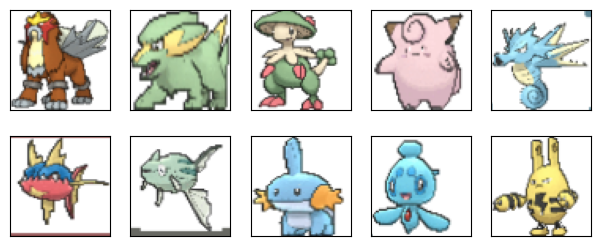

In [218]:
warnings.filterwarnings('ignore')
for i,j in realImagesDataLoader:
    # changing from n_samples x n_channels x width x height
    # to n_samples x widht x height x channels
    imgs = i[:10].permute(0,2,3,1)
    show_images(imgs,2,5)
    break

## Defining the GAN

Defining Repetitive classes

In [219]:
class ConvLeakyReLU(nn.Module):
    def __init__(self, in_channels, out_channels, alpha, kernel_size=4, stride=2, padding=1):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels,out_channels,kernel_size,stride,padding,bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(negative_slope=alpha, inplace=True)
        )

    def forward(self, x):
        return self.conv(x)
    
class ConvReLU(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=4, stride=2, padding=1):
        super().__init__()
        self.conv = nn.Sequential(
            nn.ConvTranspose2d(in_channels,out_channels,kernel_size,stride,padding,bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        return self.conv(x)

Defining the Discriminator

In [220]:
class Discriminator(nn.Module):
    
    def __init__(self, alpha):
        super().__init__()

        # input: n_samples x 3 x 64 x 64
        self.conv1 = ConvLeakyReLU(3, 64, alpha)
        self.conv2 = ConvLeakyReLU(64, 128, alpha)
        self.conv3 = ConvLeakyReLU(128, 256,alpha)
        self.conv4 = ConvLeakyReLU(256,512,alpha)
        self.final_conv = nn.Conv2d(512, 1, 4, 1, 0,bias=False)
        # not applying sigmoid to use BCEWithLogitsLoss

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.final_conv(x)
        return x

In [221]:
x = torch.randn((10,3,64,64))
model = Discriminator(0.5)
model(x).shape

torch.Size([10, 1, 1, 1])

Defining the Generator

In [222]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()

        # 3 input of size n_samples x 100 x 1 x 1
        self.conv1 = ConvReLU(100, 512, 4, 1, 0)
        self.conv2 = ConvReLU(512, 256)
        self.conv3 = ConvReLU(256, 128)
        self.conv4 = ConvReLU(128, 64)
        self.final_conv = nn.Sequential(
            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
            nn.BatchNorm2d(3),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.final_conv(x)
        return x


In [223]:
x = torch.randn((128,100,1,1))
model = Generator()
print('final of generator:', model(x).shape)
disc = Discriminator(0.2)
disc(model(x)).shape

final of generator: torch.Size([128, 3, 64, 64])


torch.Size([128, 1, 1, 1])

## Training

Values from the paper

In [224]:
BATCH_SIZE = 128
LR = 0.0002
NUM_EPOCHS = 20
k = 20
alpha = 0.2
momentum = 0.5
betas = [0.5, 0.999]
# num_batches = len(realImagesDataLoader)//BATCH_SIZE + (len(realImagesDataLoader)%BATCH_SIZE != 0)*1

In [235]:
discriminator = Discriminator(alpha).to(device)
generator = Generator().to(device)
d_optim = torch.optim.Adam(discriminator.parameters(), lr = LR, betas=betas)
g_optim = torch.optim.Adam(generator.parameters(), lr = LR, betas=betas)
loss = nn.BCEWithLogitsLoss()

Initialising weights

In [226]:
for weight in discriminator.parameters():
    nn.init.normal_(weight, 0, 0.02)
for weight in generator.parameters():
    nn.init.normal_(weight, 0, 0.02)

In [227]:
generator

Generator(
  (conv1): ConvReLU(
    (conv): Sequential(
      (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
  )
  (conv2): ConvReLU(
    (conv): Sequential(
      (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
  )
  (conv3): ConvReLU(
    (conv): Sequential(
      (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
  )
  (conv4): ConvReLU(
    (conv): Sequential(
      (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps

In [228]:
discriminator

Discriminator(
  (conv1): ConvLeakyReLU(
    (conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
  )
  (conv2): ConvLeakyReLU(
    (conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
  )
  (conv3): ConvLeakyReLU(
    (conv): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
  )
  (conv4): ConvLeakyReLU(
    (conv): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4)

In [229]:
realImagesDataLoader = DataLoader(data, batch_size = BATCH_SIZE, shuffle=True)

In [230]:
num_batches = len(realImagesDataLoader)//BATCH_SIZE + (len(realImagesDataLoader)%BATCH_SIZE != 0)*1

In [231]:
def update_D(X, Z, discriminator, generator, loss, d_optim):
    # updating the discriminator by detaching from Generator
    batch_size = X.shape[0]
    ones = torch.ones(batch_size, device = device).view((batch_size,1))
    zeros = torch.zeros(batch_size, device = device).view((batch_size,1))
    # real images
    pred_real = discriminator(X).view((batch_size,1))
    loss_real = loss(pred_real, ones)
    # fake images
    pred_fake = discriminator(generator(Z).detach()).view((batch_size,-1))
    loss_fake = loss(pred_fake, zeros)
    loss_d = (loss_real + loss_fake)/2
    d_optim.zero_grad()
    loss_d.backward()
    d_optim.step()
    return loss_d.item()

In [232]:
def update_G(Z, discriminator, generator, g_optim, loss, batch_size):
    ones = torch.ones(batch_size, device=device).view((batch_size,1))
    loss_g  = loss(discriminator(generator(Z)).view((batch_size,1)), ones)
    g_optim.zero_grad() 
    loss_g.backward()
    g_optim.step()
    return loss_g.item()

Epoch: 1/20 | D_loss: 0.00005 | G_loss: 0.05264 | time: 145.16569


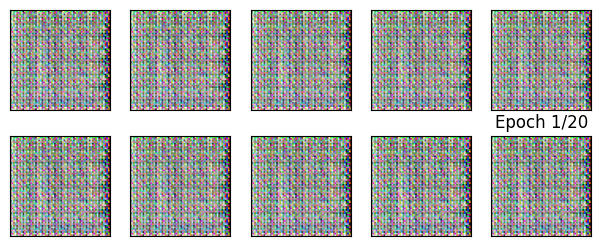

Epoch: 2/20 | D_loss: 0.00001 | G_loss: 0.05678 | time: 145.03171


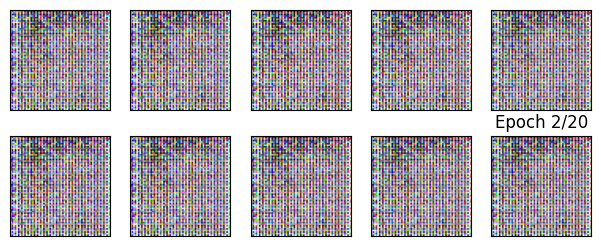

Epoch: 3/20 | D_loss: 0.00116 | G_loss: 0.05248 | time: 145.41662


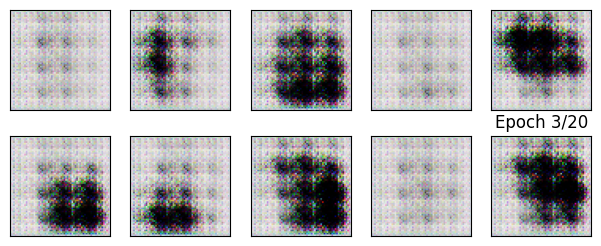

Epoch: 4/20 | D_loss: 0.00017 | G_loss: 0.05137 | time: 144.76781


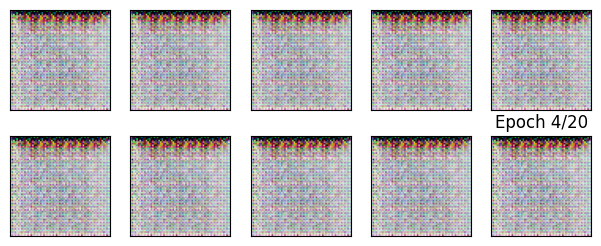

Epoch: 5/20 | D_loss: 0.00100 | G_loss: 0.04403 | time: 144.99799


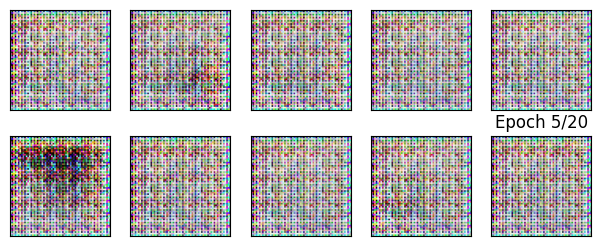

Epoch: 6/20 | D_loss: 0.00099 | G_loss: 0.04400 | time: 145.95456


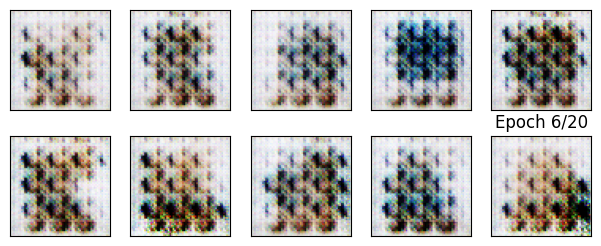

Epoch: 7/20 | D_loss: 0.00129 | G_loss: 0.04093 | time: 146.62250


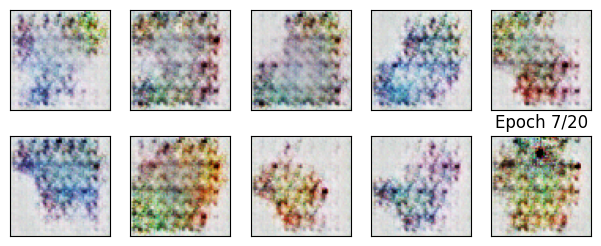

Epoch: 8/20 | D_loss: 0.00147 | G_loss: 0.03756 | time: 145.32484


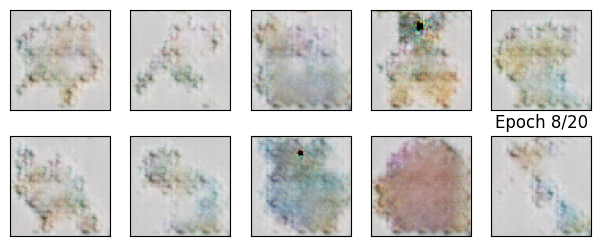

Epoch: 9/20 | D_loss: 0.00163 | G_loss: 0.03717 | time: 282.69112


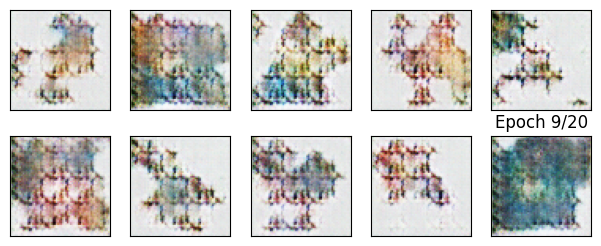

Epoch: 10/20 | D_loss: 0.00180 | G_loss: 0.03677 | time: 178.74817


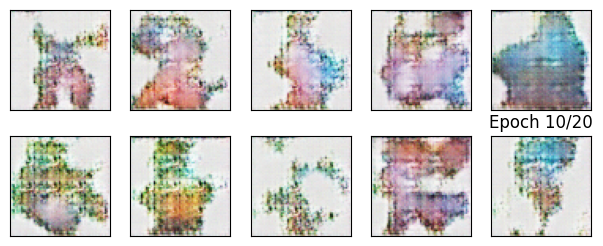

Epoch: 11/20 | D_loss: 0.00156 | G_loss: 0.03580 | time: 144.80189


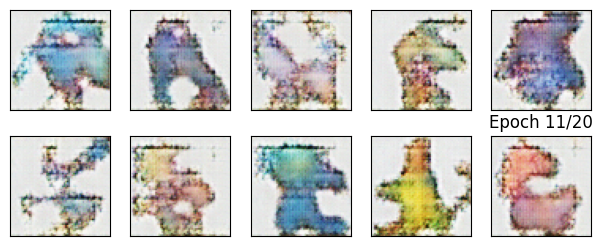

Epoch: 12/20 | D_loss: 0.00129 | G_loss: 0.03346 | time: 144.89181


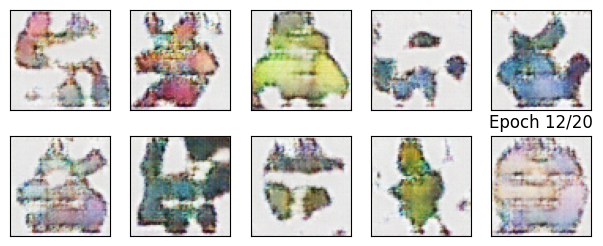

Epoch: 13/20 | D_loss: 0.00138 | G_loss: 0.03271 | time: 145.15451


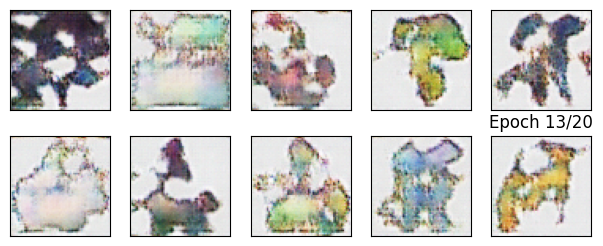

Epoch: 14/20 | D_loss: 0.00110 | G_loss: 0.03194 | time: 144.63469


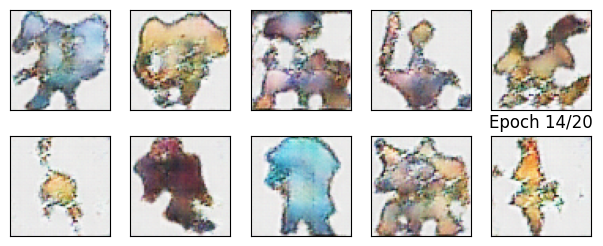

Epoch: 15/20 | D_loss: 0.00147 | G_loss: 0.03033 | time: 144.44601


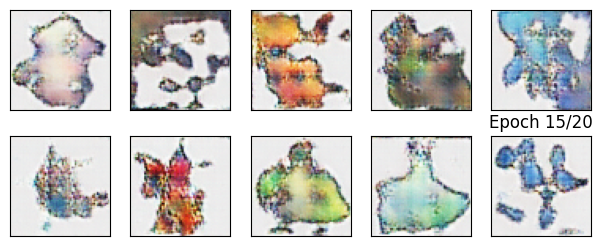

Epoch: 16/20 | D_loss: 0.00118 | G_loss: 0.03325 | time: 144.43415


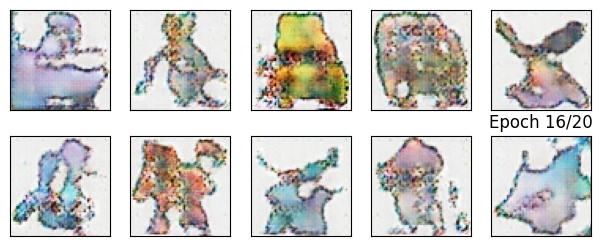

Epoch: 17/20 | D_loss: 0.00087 | G_loss: 0.03342 | time: 144.20760


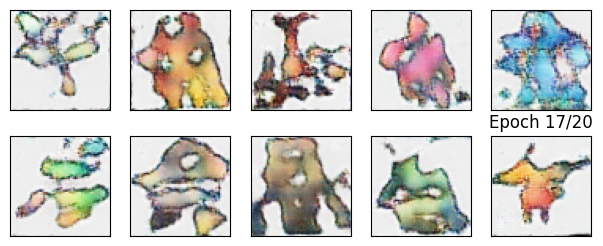

Epoch: 18/20 | D_loss: 0.00097 | G_loss: 0.03270 | time: 144.36021


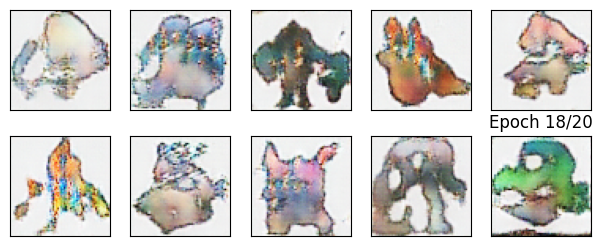

Epoch: 19/20 | D_loss: 0.00150 | G_loss: 0.03163 | time: 144.26329


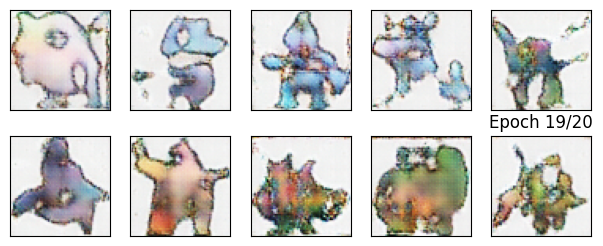

Epoch: 20/20 | D_loss: 0.00099 | G_loss: 0.03185 | time: 145.90957


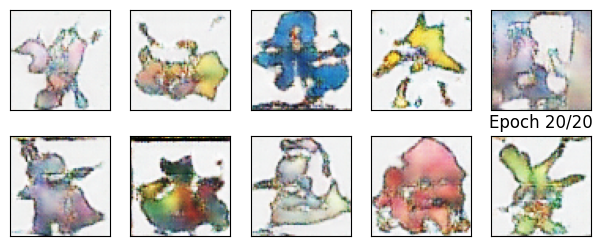

In [237]:
for epoch in range(NUM_EPOCHS):
    start_time = time.time()
    running_d_loss, running_g_loss, n_iter = 0.0, 0.0, 0
    for batch, _ in realImagesDataLoader:
        batch_size = batch.shape[0]
        Z = torch.normal(0, 1, (batch_size,100, 1, 1), device=device)
        running_d_loss += update_D(batch.to(device), Z, discriminator, generator, loss, d_optim)
        running_g_loss += update_G(Z, discriminator, generator, g_optim, loss, batch_size)
        n_iter += batch_size
    end_time = time.time()
    print(f"Epoch: {epoch+1}/{NUM_EPOCHS} | D_loss: {running_d_loss/n_iter:.5f} | G_loss: {running_g_loss/n_iter:.5f} | time: {end_time-start_time:.5f}")
    #  Display after each epoch
    show_images(generator(torch.normal(0,1,(10,100,1,1),device=device)).detach().permute(0,2,3,1).cpu(), 2, 5)
    plt.title(f"Epoch {epoch+1}/{NUM_EPOCHS}")
    plt.show()